In [3]:
from numpy import random as npr
import random
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats as scs

In [4]:
# initialization of the markov chain


In [5]:
def evolution(list_lengths):
    permutation = np.arange(32)
    npr.shuffle(permutation)
    new_lengths = [0]*32
    for k in range(32):
        if permutation[k] >= 17:
            new_lengths[k] = list_lengths[k]
        else:
            new_lengths[k] = list_lengths[k] - npr.randint(5, 11)
    return new_lengths

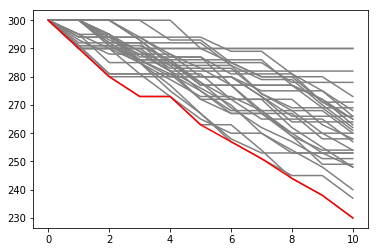

In [6]:
T = 10
list_lengths = [300]*32
big_list = [list_lengths]
for t in range(T):
    list_lengths = evolution(list_lengths)
    big_list.append(list_lengths)
for k in range(32):
    plt.plot(range(T+1), [big_list[i][k] for i in range(T+1)], color='grey')
plt.plot(range(T+1), [min(big_list[i]) for i in range(T+1)], color='red')
plt.show()

In [7]:
def evolution_simple(longueur):
    x = npr.rand()
    if x > 0.5:
        return longueur - npr.randint(5, 11)
    return longueur

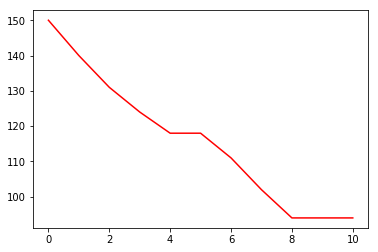

In [8]:
T = 10
longueur = 150
L = [longueur]
for t in range(T):
    longueur = evolution_simple(longueur)
    L.append(longueur)
plt.plot(range(T+1), L, color='red')
plt.show()

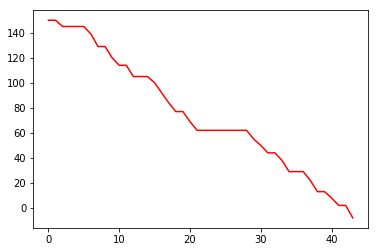

In [9]:
T = 0
longueur = 150
L = [longueur]
while longueur > 0:
    T += 1
    longueur = evolution_simple(longueur)
    L.append(longueur)
plt.plot(range(T+1), L, color='red')
plt.show()

Vérification de l'uniformité de la loi de la marche sachant qu'elle est entre 1 et 10 :

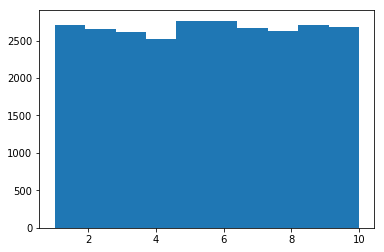

In [12]:
n_exp = 10000
L_select = []
longueur = 150
L = [longueur]*n_exp
L_finales = []
for T in range(100):
    for exp in range(n_exp):
        a = evolution_simple(L[exp])
        L[exp] = a
        if a > 0 and a <= 10:
            L_finales.append(a)
plt.hist(L_finales, bins=10)
plt.show()

Loi de $S_\tau$ et indépendance avec $\tau$ :

In [10]:
n_exp = 100000
L_finales = []
T_final = []
for exp in range(n_exp):
    T = 0
    longueur = 240
    L = [longueur]
    while longueur > 0:
        T += 1
        longueur = evolution_simple(longueur)
        L.append(longueur)
    L_finales.append(L[-1])
    T_final.append(T)

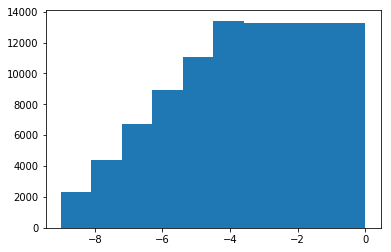

In [11]:
plt.hist(L_finales, bins=10)
plt.show()

In [89]:
np.cov(L_finales, T_final)

array([[  6.07961507,  -1.22231409],
       [ -1.22231409,  72.32270098]])